In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy.random import seed
%matplotlib inline

In [58]:
class LinearRegressionGD(object):

  def __init__(self, eta=0.001, n_iter=20, random_state=1):
    self.eta = eta
    self.n_iter = n_iter
    self.random_state = random_state

  def fit(self, X, y):
    rgen = np.random.RandomState(self.random_state)
    self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
    self.cost_ = []

    for i in range(self.n_iter):
          output = self.net_input(X)
          errors = (y - output)/ X.shape[0]
          self.w_[1:] += self.eta * X.T.dot(errors)
          self.w_[0] += self.eta * errors.sum()
          cost = ((errors*X.shape[0])**2).sum() / 2.0 / X.shape[0]
          self.cost_.append(cost)
    return self

  def net_input(self, X):
    return np.dot(X, self.w_[1:]) + self.w_[0]

  def predict(self, X):
    return self.net_input(X)

In [59]:
class AdalineSGD_2(object):
    def __init__(self, eta=0.01, n_iter=50, shuffle=True, random_state=1, mibah=1):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        self.mibah=mibah        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi in range(0,X.shape[0]-X.shape[0]%self.mibah,self.mibah):
                cost.append(self._update_weights(X[xi:xi+self.mibah], y[xi:xi+self.mibah]))
            avg_cost = sum(cost) / (len(y) / self.mibah)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.activation(xi)
        error = (target - output) / output.shape[0] 
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * error.sum()
        cost = 0.5 * ((target - output)**2).sum() / output.shape[0]
        return cost
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return self.net_input(X)

    def predict(self, X):
        return self.activation(X) 

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

In [60]:
df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [61]:
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [62]:
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

#Training data points: 1491
#Testing data points: 639


In [64]:
sc_x = StandardScaler()
sc_x = sc_x.fit(X_train)
X_train_std = sc_x.transform(X_train)
X_test_std = sc_x.transform(X_test)

In [65]:
cubic = PolynomialFeatures(degree=3)
cubic.fit(X_train_std)
X_cubic_train = cubic.transform(X_train_std)
X_cubic_test = cubic.transform(X_test_std)
print('#Features: %d' % X_cubic_train.shape[1])
s=StandardScaler()
s.fit(X_cubic_train)
X_cubic_trains = s.transform(X_cubic_train)
X_cubic_tests = s.transform(X_cubic_test)
cubic_regr = AdalineSGD_2(n_iter=2000, eta=1e-4, random_state=90, mibah=32)
cubic_regr.fit(X_cubic_trains, y_train)
y_train_pred = cubic_regr.predict(X_cubic_trains)
y_test_pred = cubic_regr.predict(X_cubic_tests)
#plt.plot(range(1, cubic_regr.n_iter + 1),cubic_regr.cost_)
#plt.ylabel('Cost')
#plt.xlabel('Epoch')
#plt.tight_layout()
#plt.show()
print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

#Features: 364
MSE train: 4232.23, test: 4366.55
R^2 train: 0.73, test: 0.74


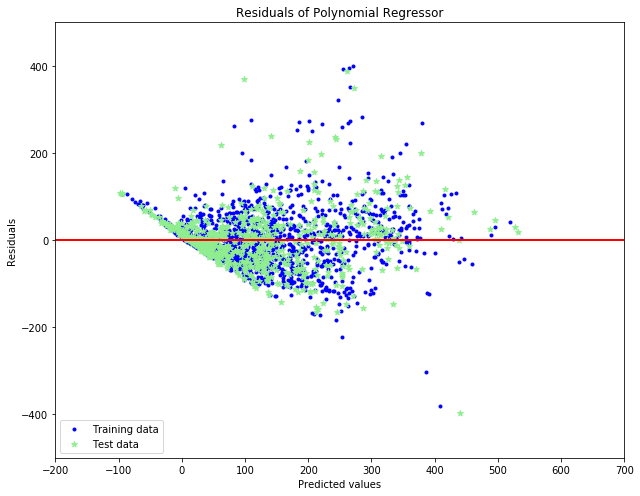

In [66]:
# Residual plot
plt.figure(figsize=(9,7))
plt.title('Residuals of Polynomial Regressor')
plt.scatter(y_train_pred, y_train-y_train_pred ,c='blue',marker='.',label='Training data')
plt.scatter(y_test_pred,  y_test-y_test_pred , c='lightgreen', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower left')
plt.hlines(y=0, xmin=-200, xmax=700, lw=2, color='red')
plt.xlim([-200, 700])
plt.ylim([-500, 500])
plt.tight_layout()
plt.show()

MSE train: 178.40, test: 1266.52
R^2 train: 0.99, test: 0.92


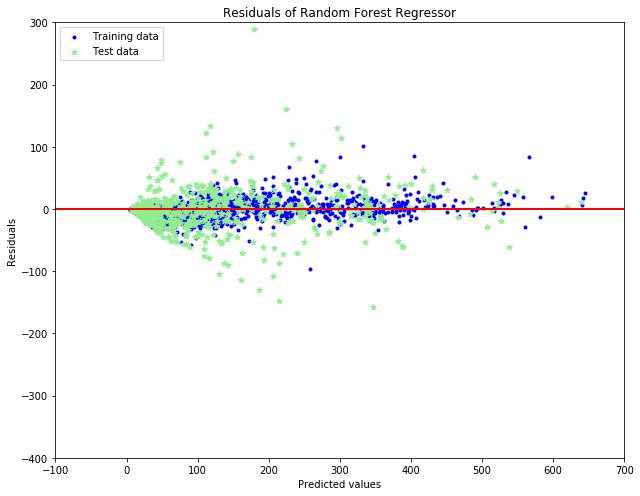

In [67]:
forest = RandomForestRegressor(n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train_std, y_train)
y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred),mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

# Residual plot
plt.figure(figsize=(9,7))
plt.title('Residuals of Random Forest Regressor')
plt.scatter(y_train_pred,y_train-y_train_pred, c='blue',marker='.',label='Training data')
plt.scatter(y_test_pred, y_test-y_test_pred, c='lightgreen', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-100, xmax=700, lw=2, color='red')
plt.ylim([-400, 300])
plt.xlim([-100, 700])
plt.tight_layout()
plt.show()

In [68]:
from sklearn.tree import DecisionTreeClassifier
#from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
forest = RandomForestClassifier(criterion='entropy',n_estimators=200,random_state=1,n_jobs=2)
forest.fit(X_train_std, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
importances_sort=importances[indices]
X_down = df.loc[idx].drop(['Ir', 'Is','year','month','TEMP'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_down, y, test_size=0.3, random_state=0)
sc_x = StandardScaler()
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.fit_transform(X_test)
print('#Training data points: %d' % X_train_std.shape[0])
print('#Testing data points: %d' % X_test_std.shape[0])

#Training data points: 1491
#Testing data points: 639


In [69]:
cubic = PolynomialFeatures(degree=3)
cubic.fit(X_train_std)
X_cubic_train = cubic.transform(X_train_std)
X_cubic_test = cubic.transform(X_test_std)
print('#Features: %d' % X_cubic_train.shape[1])
s=StandardScaler()
s.fit(X_cubic_train)
X_cubic_trains = s.transform(X_cubic_train)
X_cubic_tests = s.transform(X_cubic_test)
cubic_regr = LinearRegressionGD(eta=0.004,n_iter=600)
cubic_regr = cubic_regr.fit(X_cubic_trains, y_train)
y_train_pred = cubic_regr.predict(X_cubic_trains)
y_test_pred = cubic_regr.predict(X_cubic_tests)
#plt.plot(range(1, cubic_regr.n_iter + 1),cubic_regr.cost_)
#plt.ylabel('Cost')
#plt.xlabel('Epoch')
#plt.tight_layout()
#plt.show()
print('MSE train: %.2f, test: %.2f' % (mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),r2_score(y_test, y_test_pred)))

#Features: 120
MSE train: 661.75, test: 637.64
R^2 train: 0.96, test: 0.96


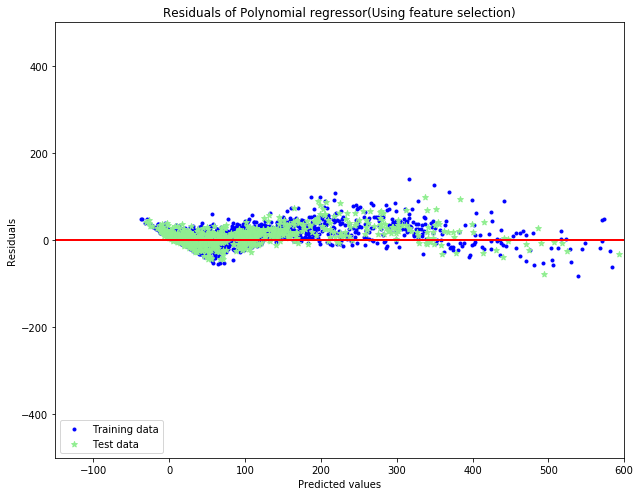

In [70]:
# Residual plot
plt.figure(figsize=(9,7))
plt.title('Residuals of Polynomial regressor(Using feature selection)')
plt.scatter(y_train_pred, y_train-y_train_pred ,c='blue',marker='.',label='Training data')
plt.scatter(y_test_pred,  y_test-y_test_pred , c='lightgreen', marker='*', label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='lower left')
plt.hlines(y=0, xmin=-150, xmax=600, lw=2, color='red')
plt.xlim([-150, 600])
plt.ylim([-500, 500])
plt.tight_layout()
plt.show()